In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from matplotlib import style
from sklearn.decomposition import PCA

from sklearn.preprocessing import Normalizer

from raman_lib.preprocessing import (BaselineCorrector,
                                     RangeLimiter,
                                     SavGolFilter)

from raman_lib.opus_converter import convert_opus

style.use("default")
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100

In [25]:
data = []
labels = []

for dir in os.listdir("./data"):
    print(dir)
    for file in os.listdir(os.path.join("./data", dir)):
        print(file)
        filepath = os.path.join("./data", dir, file)
        data.append(convert_opus(filepath))
        labels.append(dir)

W+2B
EXTRACT_Biofilm csquare W+2B.0_000005.0
EXTRACT_Biofilm csquare W+2B.0_000004.0
EXTRACT_Biofilm csquare W+2B.0_000008.0
EXTRACT_Biofilm csquare W+2B.0_000010.0
EXTRACT_Biofilm csquare W+2B.0_000006.0
EXTRACT_Biofilm csquare W+2B.0_000014.0
EXTRACT_Biofilm csquare W+2B.0_000007.0
EXTRACT_Biofilm csquare W+2B.0_000015.0
EXTRACT_Biofilm csquare W+2B.0_000012.0
EXTRACT_Biofilm csquare W+2B.0_000011.0
EXTRACT_Biofilm csquare W+2B.0_000000.0
EXTRACT_Biofilm csquare W+2B.0_000003.0
EXTRACT_Biofilm csquare W+2B.0_000001.0
EXTRACT_Biofilm csquare W+2B.0_000002.0
EXTRACT_Biofilm csquare W+2B.0_000013.0
EXTRACT_Biofilm csquare W+2B.0_000009.0
2B
EXTRACT_Biofilm csquare 2B.1_000003.0
EXTRACT_Biofilm csquare 2B.1_000006.0
EXTRACT_Biofilm csquare 2B.1_000001.0
EXTRACT_Biofilm csquare 2B.1_000012.0
EXTRACT_Biofilm csquare 2B.1_000014.0
EXTRACT_Biofilm csquare 2B.1_000005.0
EXTRACT_Biofilm csquare 2B.1_000011.0
EXTRACT_Biofilm csquare 2B.1_000015.0
EXTRACT_Biofilm csquare 2B.1_000013.0
EXTRACT_Bi

In [26]:
data = np.asarray(data)
wns = data[0,:,0]
X = data[:,:,1]

y = np.asarray(labels)
y, y_key = pd.factorize(y)

In [27]:
for i, label in enumerate(y_key):
    print(f"{label}: {i}")

W+2B: 0
2B: 1
W: 2
1B: 3
PW: 4
W+1B: 5


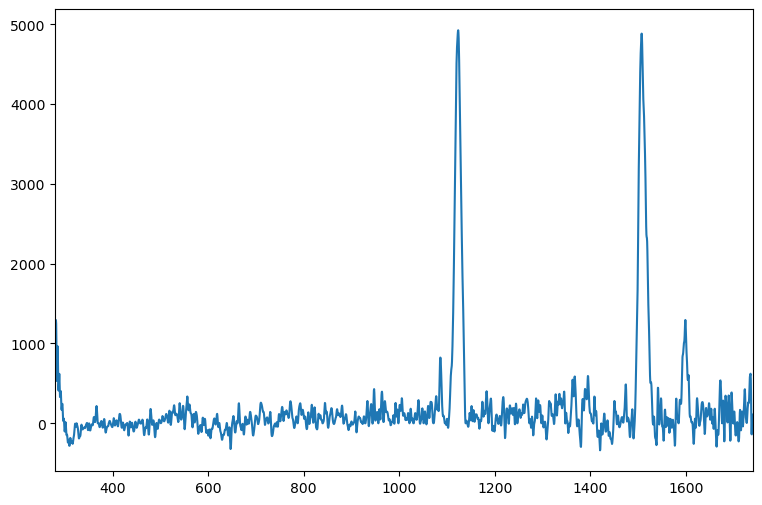

In [28]:
plt.plot(wns, X[0])
plt.margins(x=0)

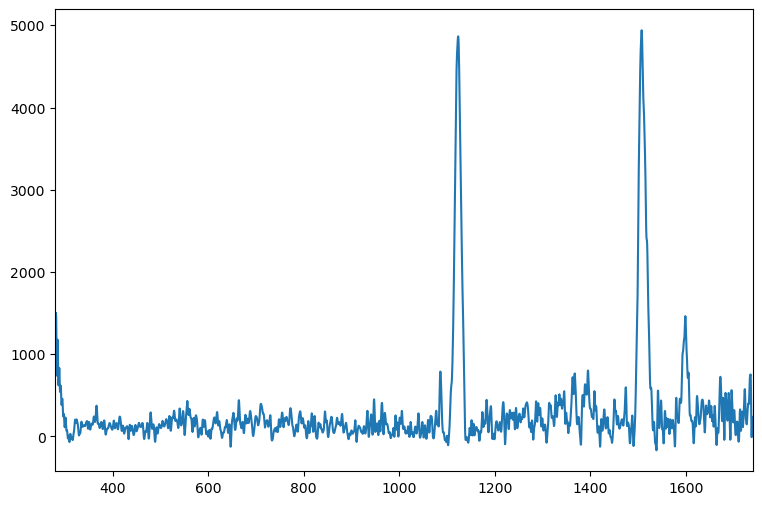

In [29]:
X_orig = X.copy()

X = BaselineCorrector().fit_transform(X)

plt.plot(wns, X[0])
plt.margins(x=0)

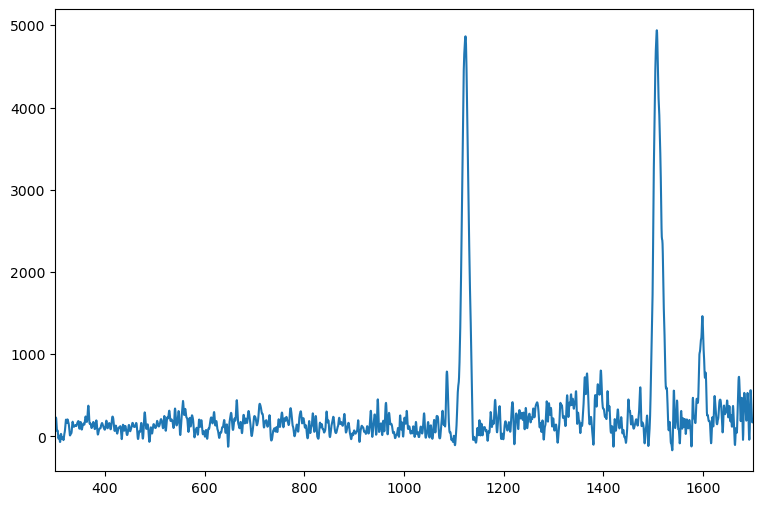

In [30]:
rl = RangeLimiter(lim=(300, 1700), reference=wns)
X = rl.fit_transform(X)
wns_reduced = wns[rl.lim_[0]:rl.lim_[1]]

plt.plot(wns_reduced, X[0])
plt.margins(x=0)

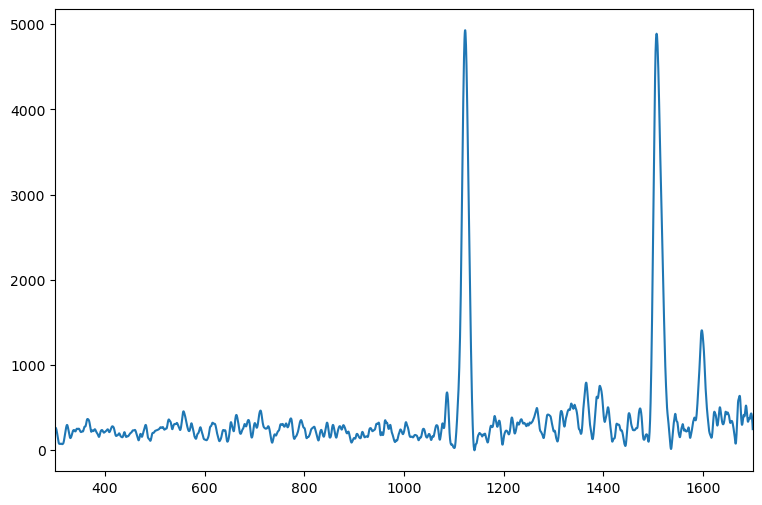

In [31]:
X = SavGolFilter(window=25).fit_transform(X)

plt.plot(wns_reduced, X[0])
plt.margins(x=0)

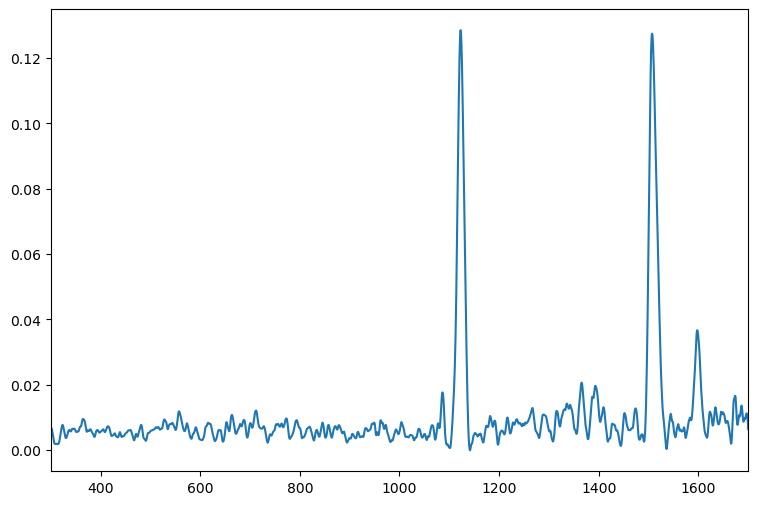

In [32]:
X = Normalizer().fit_transform(X)

plt.plot(wns_reduced, X[0])
plt.margins(x=0)

In [33]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

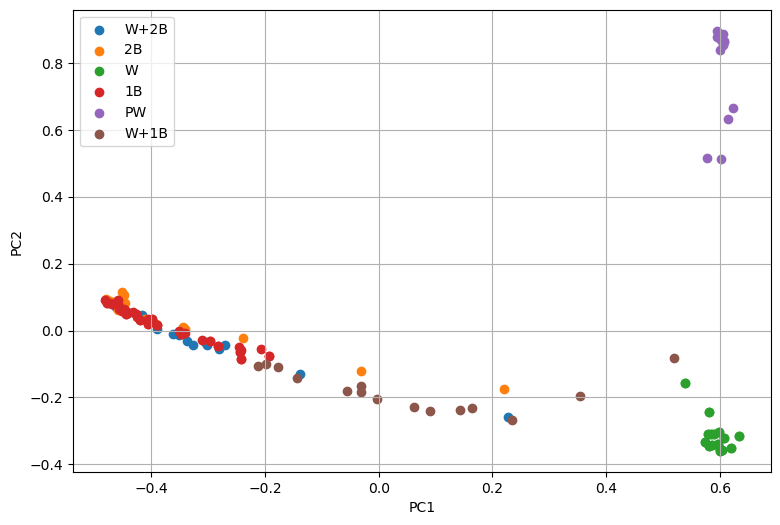

In [34]:
for i in range(len(y_key)):
    plt.scatter(X_pca[y==i, 0], X_pca[y==i, 1], label = y_key[i])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.grid()

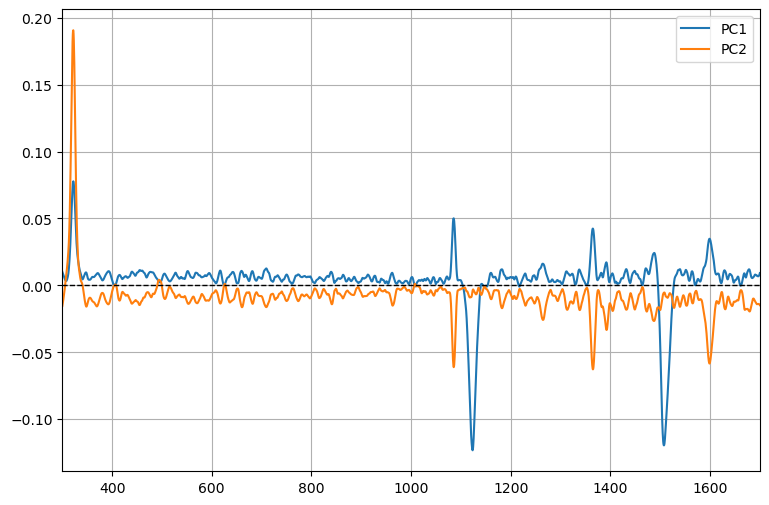

In [35]:
for i, component in enumerate(pca.components_):
    plt.plot(wns_reduced, component, label=f"PC{i+1}")


plt.axhline(y=0, linestyle="--", linewidth=1, color="k")

plt.margins(x=0)

plt.legend()

plt.grid()